# Day Trade Algortithm
## Toy Model Back-Testing

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss
from sklearn import linear_model
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [3]:
# define daterange
start_date = datetime(2019,3,14)
end_date = datetime(2024,8,30)

# prepare features
feature = pd.read_csv('/content/INFO6105_FeatureMart_with_meta_indicators.csv', index_col = [1])
feature['Date'] = pd.to_datetime(feature['Date'])
feature = feature.set_index('Date')

# fetch target variable (stock price or stock returns)
stock_symbol = 'META'
stock = yf.download(stock_symbol, start_date, end_date)
print(stock_symbol + ' Stock Price History')
print(stock.head())

# Correct the column names after merging
stock.columns = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

# Reset the index before merging
stock.reset_index(inplace=True)
feature.reset_index(inplace=True)

# Perform the merge
data_frame = pd.merge(feature, stock, how='inner', on='Date')

# Handle missing values and reset the index
data_frame.fillna(method='ffill', inplace=True)
data_frame.reset_index(drop=True, inplace=True)


[*********************100%***********************]  1 of 1 completed

META Stock Price History
Price        Adj Close       Close        High         Low        Open  \
Ticker            META        META        META        META        META   
Date                                                                     
2019-03-14  169.659180  170.169998  171.149994  168.160004  169.759995   
2019-03-15  165.481750  165.979996  167.580002  162.509995  167.160004   
2019-03-18  159.988297  160.470001  163.899994  159.279999  163.570007   
2019-03-19  161.084991  161.570007  163.820007  160.820007  161.479996   
2019-03-20  164.943390  165.440002  166.119995  161.240005  161.500000   

Price         Volume  
Ticker          META  
Date                  
2019-03-14  18037400  
2019-03-15  37135400  
2019-03-18  37524200  
2019-03-19  25611500  
2019-03-20  20211500  



<ipython-input-3-a78c3e8c2232>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame.fillna(method='ffill', inplace=True)


In [4]:
# Remove the existing 'log_return' column if present
if 'log_return' in data_frame.columns:
    data_frame = data_frame.drop('log_return', axis=1)

# Calculate log return using the previous day's Close price
data_frame['log_return'] = np.log(data_frame['Close'] / data_frame['Close'].shift(1))

# Drop missing values created by the shift operation
data_frame.dropna(inplace=True)

# Verify the change by checking the first few rows
print(data_frame[['Open', 'Close', 'log_return']].head())


          Open       Close  log_return
12  168.193588  167.279999    0.014876
13  173.677078  169.550003    0.013479
14  173.019058  172.949997    0.019855
15  175.491623  175.529999    0.014807
16  175.192520  175.100006   -0.002453


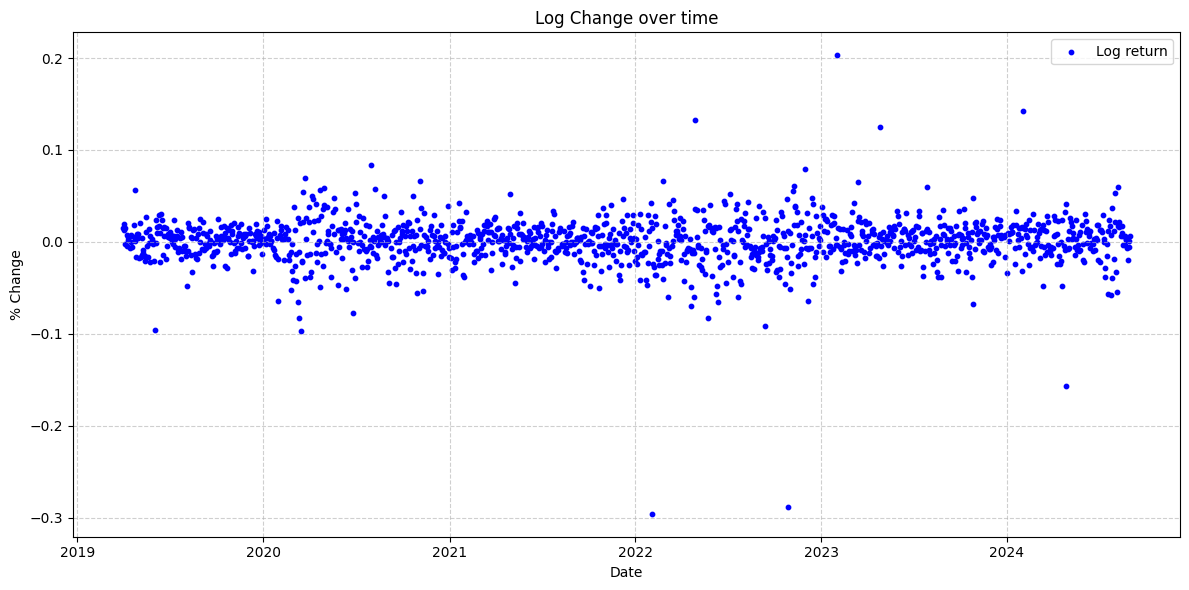

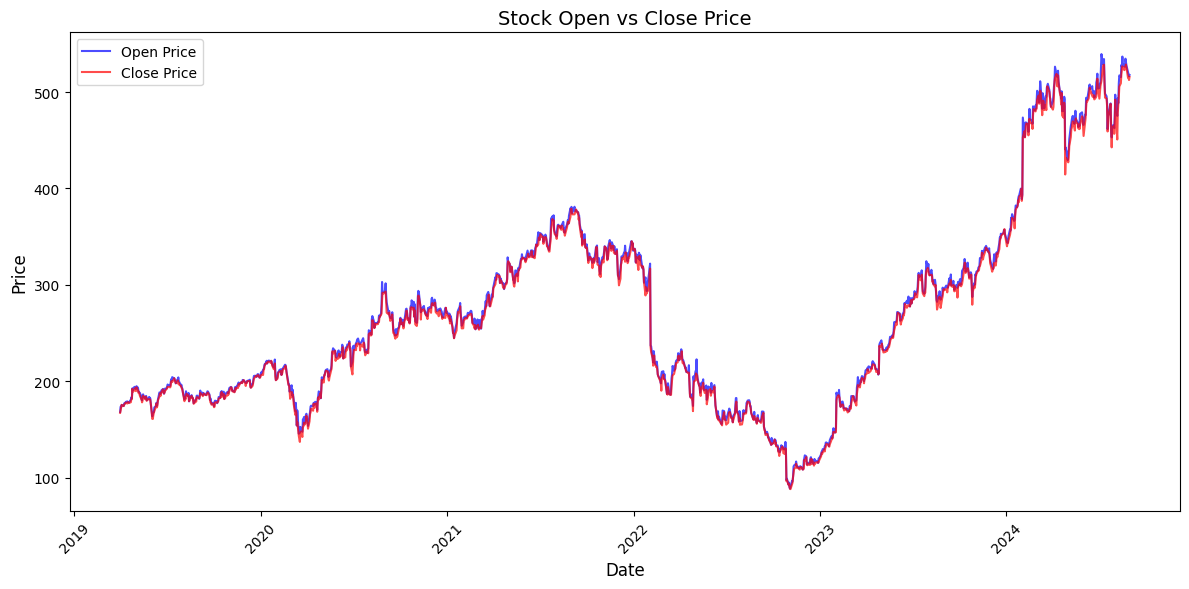

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(data_frame['Date'], data_frame['log_return'], label='Log return', color='blue', s=10)
plt.title('Log Change over time')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
data_frame

## Feature importance

## trainig

In [10]:
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=200,         # Increase for better learning
#     learning_rate=0.05,       # Lower learning rate
#     max_depth=3,
#     random_state = 42
# )

# Step 7: Initialize the XGBoost model with tuned hyperparameters
model = xgb.XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42)

## log return as target model

In [12]:
features = ['RSI','RF','CMA','HML','Volatility','VIXCLS','RMW','SMB']

## old log code

In [14]:
# Assuming the necessary features are defined

target = 'log_return'

# Assuming data_frame is already loaded
# data_frame['log_return'] = np.log(data_frame['Close'] / data_frame['Open'])

# Drop rows with missing values
data_frame = data_frame.dropna()

# Split the data into features and target variable
X = data_frame[features]
y = data_frame[target]

# Train-test split
train_size = int(0.90 * len(data_frame))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the XGBoost model
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=1000,         # Increase for better learning
#     learning_rate=0.01,       # Lower learning rate
#     max_depth=50,
#     random_state=42# Moderate tree depth
# )
model.fit(X_train, y_train)

# Trading simulation setup
start_date_index = 252
initial_balance = 50000
balance = {start_date_index: initial_balance}
position = 100
signal = {}
gain_loss = {}

# Trading loop
for today in range(start_date_index, len(data_frame) - 1):
    try:
        # Prepare test data for prediction
        X_test_today = data_frame.iloc[today:today+1][features]  # Fixed indexing

        # Predict the log return for tomorrow
        y_pred_tomorrow = model.predict(X_test_today)[0]  # Added [0] to get scalar value

        # Get actual prices
        actual_open = data_frame['Open'].iloc[today + 1]
        actual_close = data_frame['Close'].iloc[today + 1]

        # Trading logic
        if y_pred_tomorrow > 0:
            signal[today + 1] = 1
            trade_gain_loss = (actual_close - actual_open) * position
        else:
            signal[today + 1] = -1
            trade_gain_loss = (actual_open - actual_close) * position

        # Update balance
        prev_balance = balance[today]  # Use direct indexing
        balance[today + 1] = prev_balance + trade_gain_loss
        gain_loss[today + 1] = trade_gain_loss

    except Exception as e:
        print(f"Error at index {today}: {e}")
        balance[today] = balance[today - 1]

# Create results DataFrame
results = pd.DataFrame({
    'Signal': pd.Series(signal),
    'Gain/Loss': pd.Series(gain_loss),
    'Balance': pd.Series(balance)
})

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, model.predict(X_test)))
print("R² Score:", r2_score(y_test, model.predict(X_test)))

# Display all unique values in the 'Signal' column
unique_signals = results['Signal'].unique()
print("\nUnique Signals:", unique_signals)

# Display the frequency of each unique value
signal_counts = results['Signal'].value_counts()
print("Signal Counts:", signal_counts)

from sklearn.metrics import mean_squared_error

# Collect predictions and actual values from the test set
predictions = []
actuals = []

# Re-run trading loop with prediction collection
for today in range(start_date_index, len(data_frame) - 1):
    try:
        # Prepare test data for prediction
        X_test_today = data_frame.iloc[today:today+1][features]

        # Predict the next day's percentage change
        y_pred_tomorrow = model.predict(X_test_today)[0]

        # Collect prediction and actual value
        predictions.append(y_pred_tomorrow)
        actuals.append(data_frame[target].iloc[today + 1])

    except Exception as e:
        print(f"Error at index {today}: {e}")

# Calculate RMSE
rmse = mean_squared_error(actuals, predictions, squared=False)
print(f"RMSE: {rmse:.4f}")



# MAE: 0.00763851055363586
# R² Score: 0.08150068899823881

# Unique Signals: [-1.  1. nan]
# Signal Counts: Signal
# -1.0    1015
#  1.0      96


MAE: 0.01553040760032162
R² Score: 0.018604585676210372

Unique Signals: [nan  1. -1.]
Signal Counts: Signal
 1.0    702
-1.0    409
Name: count, dtype: int64
RMSE: 0.0295


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(y_pred_tomorrow)

-0.0012719943


## old plot code

Strategy Total Return: $-79,235.03
Buy & Hold Total Return: $105,045.76
Strategy Return Percentage: -158.47%
Buy & Hold Return Percentage: 210.09%


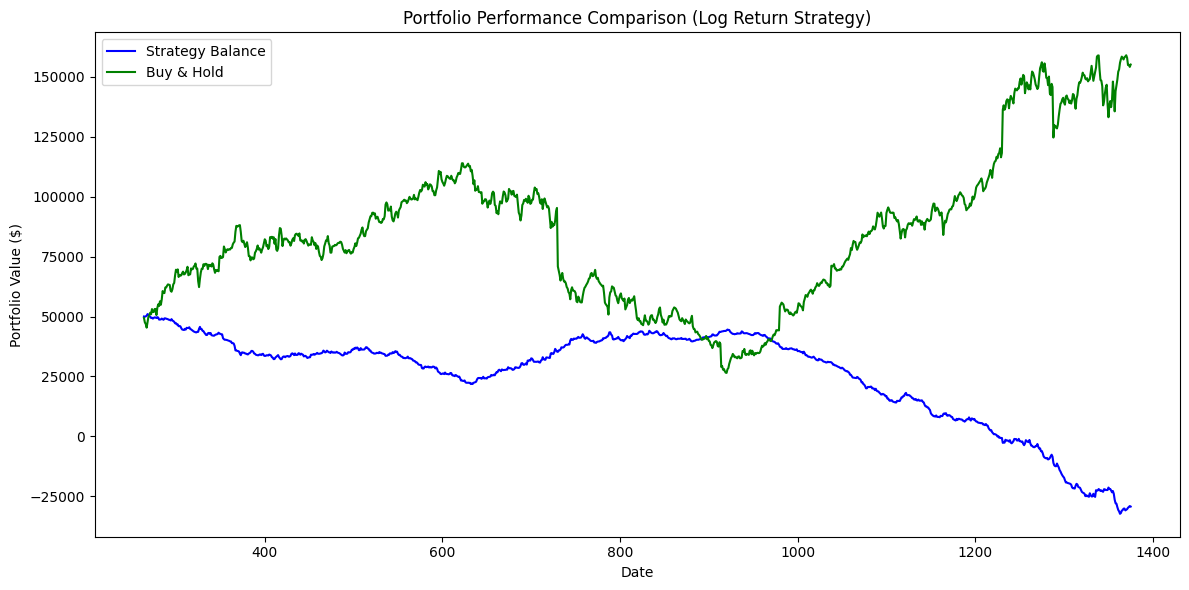

In [16]:
# Add the Date column using the stock index
results['Date'] = data_frame.index[results.index]
results.set_index('Date', inplace=True)

# --- Calculate Buy and Hold Strategy ---
initial_purchase_price = data_frame['Open'].iloc[start_date_index]
shares_purchased = initial_balance / initial_purchase_price

# Buy & Hold value over time
results['Buy_Hold'] = initial_balance + (
    data_frame['Close'].loc[results.index] - initial_purchase_price
) * shares_purchased

# --- Calculate Performance Metrics ---
results['Cumulative_Return'] = (results['Balance'] - initial_balance) / initial_balance * 100
results['Buy_Hold_Return'] = (results['Buy_Hold'] - initial_balance) / initial_balance * 100

# --- Performance Comparison ---
strategy_total_return = results['Balance'].iloc[-1] - initial_balance
buy_hold_return = results['Buy_Hold'].iloc[-1] - initial_balance

print(f"Strategy Total Return: ${strategy_total_return:,.2f}")
print(f"Buy & Hold Total Return: ${buy_hold_return:,.2f}")
print(f"Strategy Return Percentage: {strategy_total_return / initial_balance * 100:.2f}%")
print(f"Buy & Hold Return Percentage: {buy_hold_return / initial_balance * 100:.2f}%")

# --- Visualize Performance ---
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Balance'], label='Strategy Balance', color='b')
plt.plot(results.index, results['Buy_Hold'], label='Buy & Hold', color='g')
plt.title('Portfolio Performance Comparison (Log Return Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.tight_layout()
plt.show()

